In [1]:
!pip3 install scanpy

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [3]:
adata = ad.read_h5ad('E9.5_E1S1.MOSTA.h5ad')

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

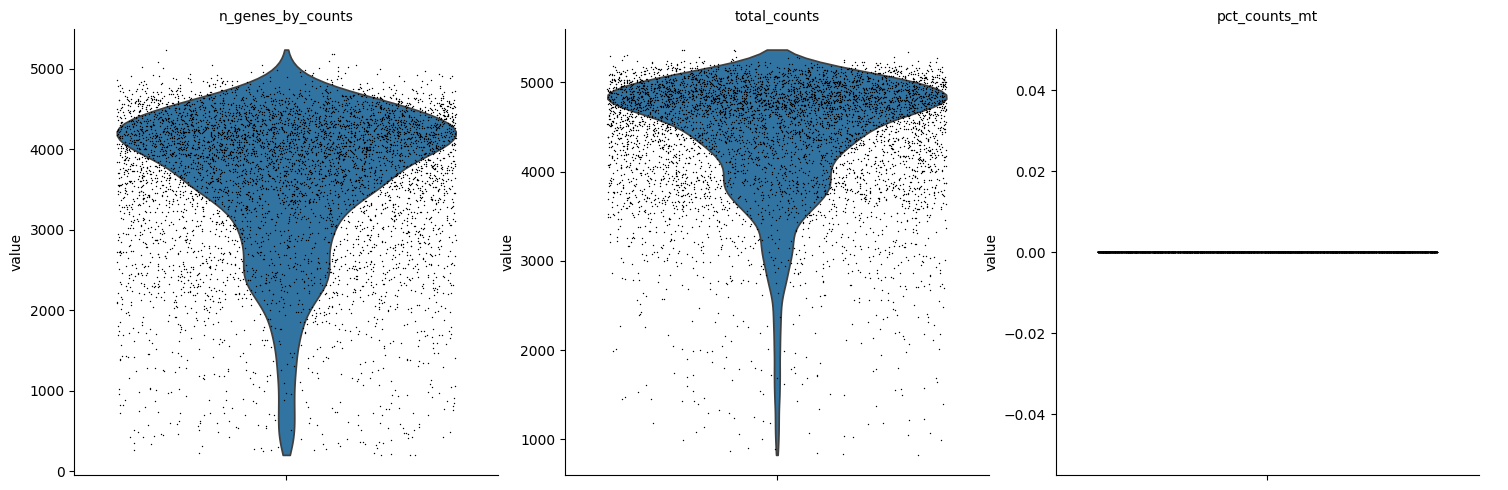

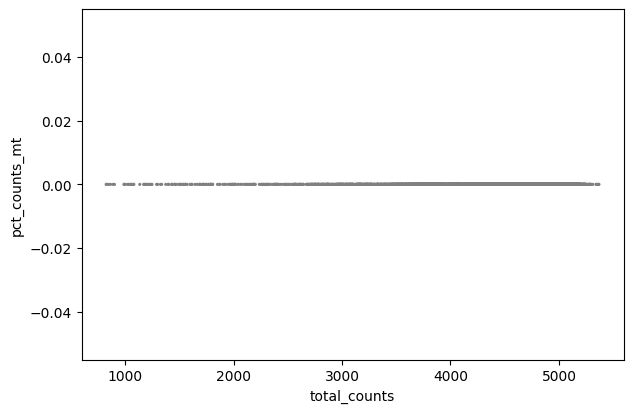

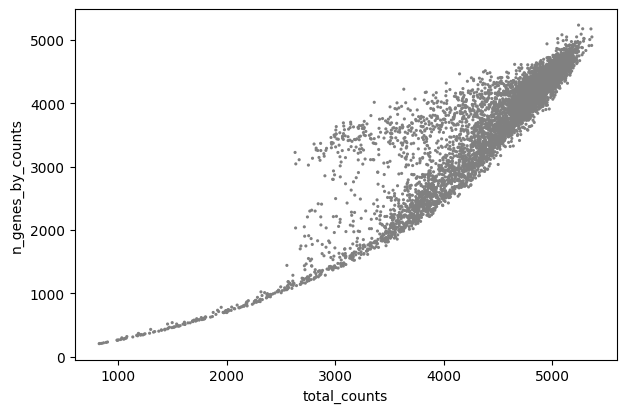

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [7]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [8]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [9]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the spatial coordinates
spatial_coords = adata.obsm['spatial']
spatial_coords_standardized = scaler.fit_transform(spatial_coords)


# Fit and transform the PCA features
pca_features = adata.obsm['X_pca']
pca_features_standardized = scaler.fit_transform(pca_features)

# Concatenate the standardized PCA features and spatial coordinates
X = scaler.fit_transform(np.hstack([pca_features, spatial_coords]))

Y = adata.obs['annotation'].to_numpy()
cell_Indexes = adata.obs.index.to_numpy()

# Generate a permutation of index array
np.random.seed(42)  # for reproducibility, you can remove or change the seed if randomness is preferred
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle X and Y and Cell_Indexes using the same indices
X_shuffled = X[indices]
Y_shuffled = Y[indices]
cell_Indexes_shuffled = cell_Indexes[indices]

In [13]:
# Define the number of folds and L value
k_fold = 5
combination_num = 3

K_list = [3, 5, 7]
L_list = [2, 3, 5]

# Initialize StratifiedKFold and classifier
skf = StratifiedKFold(n_splits=k_fold)

classifier1 = SVC(kernel='rbf', C=1.0, gamma='scale')  
classifier2 = RandomForestClassifier(n_estimators=100, max_depth=None, max_features="sqrt")
classifier3 = KNeighborsClassifier(n_neighbors=20)
classifier4 = GradientBoostingClassifier(n_estimators=20, max_depth=5, learning_rate=1) 
classifier5 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)  
classifier6 = RandomForestClassifier(n_estimators=200, max_depth=10, max_features="log2")
classifier7 = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.5) 
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6, classifier7]
classifiers_names = ["SVC", "Random Forest - max_depth=None", "KNeighbors", "Gradient Boosting - n_estimators=10", "LogisticRegression", "Random Forest - max_depth=10", "Gradient Boosting - n_estimators=50"]

In [12]:
for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]

    # Initialize predictions dictionary with keys as cell indexes and values as empty lists or arrays of size K
    predictions = {index: np.empty(K, dtype=object) for index in cell_Indexes_shuffled}

    # Metrics storage
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Training and prediction
    classifier_index = 0
    for classifier_index in range(0,K):
        for train_index, test_index in skf.split(X_shuffled, Y_shuffled):
            X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
            y_train, y_test = Y_shuffled[train_index], Y_shuffled[test_index]
            cell_indexes_test = cell_Indexes_shuffled[test_index]  # Get the cell indexes for the test set

            classifier = classifiers[classifier_index]

            # Train the model
            classifier.fit(X_train, y_train)
            
            # Predict on the test set
            preds = classifier.predict(X_test)

            # Store predictions in the dictionary using the cell indexes
            for idx, cell_index in enumerate(cell_indexes_test):
                predictions[cell_index][classifier_index] = preds[idx]
            
            # Evaluate predictions
            acc = accuracy_score(y_test, preds)
            prec = precision_score(y_test, preds, average='macro')
            rec = recall_score(y_test, preds, average='macro')
            f1 = f1_score(y_test, preds, average='macro')

            # Print metrics
            print(f"{classifiers_names[classifier_index]} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

            # Append metrics to lists for average calculation later
            accuracy_scores.append(acc)
            precision_scores.append(prec)
            recall_scores.append(rec)
            f1_scores.append(f1)
        print("--------------------------------------------------------------------------------------------------------------------------------------------")

    # Calculate and print average scores
    print("Average Accuracy:", np.mean(accuracy_scores))
    print("Average Precision:", np.mean(precision_scores))
    print("Average Recall:", np.mean(recall_scores))
    print("Average F1 Score:", np.mean(f1_scores))
    print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")


    number_of_changed = 0
    # Process each cell index and its predictions
    for cell_index, preds in predictions.items():
        # Count occurrences of each annotation
        pred_count = Counter(preds)

        most_common_pred, count = pred_count.most_common(1)[0]

        
        if count > L:
            if adata.obs.loc[cell_index, 'annotation'] != most_common_pred:
                #adata.obs.loc[cell_index, 'annotation'] = most_common_pred
                number_of_changed += 1

    print(number_of_changed)

Classifier 1 - Accuracy: 0.9080068143100511, Precision: 0.9091817814517364, Recall: 0.8869450842587617, F1 Score: 0.8968283397641298
Classifier 1 - Accuracy: 0.9020442930153322, Precision: 0.9000123588700985, Recall: 0.8810581898013142, F1 Score: 0.8898841872490689
Classifier 1 - Accuracy: 0.9173764906303237, Precision: 0.924608123620087, Recall: 0.9000384422388986, F1 Score: 0.9106691998564761
Classifier 1 - Accuracy: 0.9165247018739353, Precision: 0.9240426075437186, Recall: 0.9067890579216837, F1 Score: 0.9147847182209343
Classifier 1 - Accuracy: 0.8986371379897785, Precision: 0.9208883576776498, Recall: 0.8765981926725374, F1 Score: 0.8959649038633878
--------------------------------------------------------------------------------------------------------------------------------------------
Classifier 2 - Accuracy: 0.9173764906303237, Precision: 0.9234681655323778, Recall: 0.9003898539064626, F1 Score: 0.9099199706945655
Classifier 2 - Accuracy: 0.9293015332197615, Precision: 0.9307